In [141]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt


In [142]:
dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%Y') for d in dates]

#read in the ACT Pedestrian Crash Data (with custom fades)
act_data = []
act_data = pd.read_csv('Pedestrian_Crashes_Fades.csv',parse_dates=['CrashDate'], date_parser=dateparse)
act_data['CasScale'] = act_data.Casualties + 1

In [143]:
#display the first 5 entries

act_data.head()

,CrashID,CrashDate,Year,Month,Day,CrashTime,Severity,SevIndex,CrashType,Pedestrians,...,Fad1804,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale
0,1145041,2016-10-07,2016,10,7,8:45,Injury,0.7,Struck pedestrian (On Road),1,...,0.359714,0.341728,0.324087,0.307883,0.291989,0.276916,0.263070,0.249489,0.237015,2
1,1095195,2014-09-15,2014,9,15,16:20,Property Damage Only,0.1,Struck pedestrian (On Road),1,...,0.008697,0.007828,0.007020,0.006318,0.005666,0.005082,0.004574,0.004102,0.003692,1
2,1075343,2013-11-23,2013,11,23,21:00,Property Damage Only,0.1,Struck pedestrian (On Road),1,...,0.003075,0.002768,0.002482,0.002234,0.002004,0.001797,0.001617,0.001450,0.001305,1
3,1121518,2015-08-31,2015,8,31,20:10,Injury,0.7,Struck pedestrian (On Road),1,...,0.180597,0.171567,0.162711,0.154575,0.146595,0.139028,0.132076,0.125258,0.118995,2
4,1059958,2013-04-19,2013,4,19,13:15,Property Damage Only,0.1,Struck pedestrian (On Road),1,...,0.001430,0.001287,0.001154,0.001039,0.000932,0.000836,0.000752,0.000675,0.000607,1


In [144]:
#Tidy up the column names

act_data = act_data.rename(index=str, columns={
    "Crash Date": "CrashDate",
    "Crash ID": "CrashID",
    "Crash Time": "CrashTime",
    "Crash Type": "CrashType",
    "Pedestrian Casualties": "Casualties",
    "Reported Location": "ReportedLocation"})

In [145]:
#Pull the coordinates out into a list of tuples for conversion
#from longtitude/latitude to GDA94 / MGA zone 55 projection

zipped_coordinates = list(zip(act_data['Long'], act_data['Latt']))

zipped_coordinates[0:5]

[(149.091489, -35.354768),
 (149.036867, -35.356968),
 (149.13187299999998, -35.319716),
 (149.132745, -35.278106),
 (149.129052, -35.278394)]

In [146]:
#Convert into a new list of tuples

epsg4326 = pyproj.Proj(init='epsg:4326')
epsg28355 = pyproj.Proj(init='epsg:28355')

convert_coordinates = []

for x, y in zipped_coordinates:
    convert_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
convert_coordinates[:5]


[(690038.5018392887, 6085605.817990238),
 (685069.6671218174, 6085465.303460039),
 (693792.180088295, 6089415.764504785),
 (693970.785504186, 6094029.7478080075),
 (693634.1733990454, 6094005.01975513)]

In [148]:
#create crs variable for GeoDataFrame

crs = {'init': 'epsg:28355'}

# save the minimum and maximum coordinates for use 
# in limiting the axes - as we plot roads (larger) as well as pedestrian
# crash incidents
min_x = min([x for x,y in convert_coordinates])
min_y = min([y for x,y in convert_coordinates])
max_x = max([x for x,y in convert_coordinates])
max_y = max([y for x,y in convert_coordinates])

In [149]:
#create geometry variable for GeoDataFrame

geometry = [Point(x, y) for x, y in convert_coordinates]

geometry[0:5]

In [150]:
#create GeoDataFrame
act_geo_df = gpd.GeoDataFrame(act_data, crs=crs, geometry=geometry)

compare_date = datetime.datetime(2012,3,1,0,0,0)
#act_geo_df.head()
act_geo_filt = act_geo_df[act_geo_df.CrashDate < compare_date]
#   act_geo_df.query('CrashDate < "d(2012-03-01)"') 
act_geo_filt.head()

,CrashID,CrashDate,Year,Month,Day,CrashTime,Severity,SevIndex,CrashType,Pedestrians,...,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale,geometry
5,1057147,2012-02-11,2012,2,11,23:32,Injury,0.7,Struck pedestrian (On Road),1,...,0.018679,0.017715,0.016829,0.015960,0.015136,0.014379,0.013637,0.012955,2,POINT (693642.4672990409 6093942.028036471)
8,1029600,2012-02-18,2012,2,18,21:28,Injury,0.7,Struck pedestrian (On Road),1,...,0.018904,0.017928,0.017032,0.016152,0.015319,0.014553,0.013801,0.013111,2,POINT (693832.0577748099 6094273.664358769)
14,1028560,2012-02-11,2012,2,11,17:00,Injury,0.7,Struck pedestrian (On Road),1,...,0.018679,0.017715,0.016829,0.015960,0.015136,0.014379,0.013637,0.012955,2,POINT (693426.4095961468 6080126.529594047)
47,1026849,2012-01-28,2012,1,28,10:30,Injury,0.7,Struck pedestrian (On Road),1,...,0.018237,0.017296,0.016431,0.015583,0.014778,0.014039,0.013315,0.012649,2,POINT (693948.4305742367 6095982.890162012)
91,1057122,2012-01-21,2012,1,21,21:10,Injury,0.7,Struck pedestrian (On Road),1,...,0.018020,0.017090,0.016235,0.015397,0.014602,0.013872,0.013156,0.012498,2,POINT (689025.0539096557 6102512.062819285)


In [167]:
act_geo_df.query('SevIndex == 1')

,CrashID,CrashDate,Year,Month,Day,CrashTime,Severity,SevIndex,CrashType,Pedestrians,...,Fad1805,Fad1806,Fad1807,Fad1808,Fad1809,Fad1810,Fad1811,Fad1812,CasScale,geometry
46,1051009,2012-11-02,2012,11,2,10:09,Fatal,1.0,Struck pedestrian (Off Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (689525.7920935934 6086251.533768143)
49,1057313,2012-10-12,2012,10,12,16:25,Fatal,1.0,Struck pedestrian (On Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (688228.617050383 6096451.019296845)
61,1068770,2013-08-16,2013,8,16,16:56,Fatal,1.0,Struck pedestrian (On Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (690859.451010164 6084777.630298873)
88,1057306,2012-05-03,2012,5,3,16:40,Fatal,1.0,Struck pedestrian (On Road),2,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3,POINT (690817.8615282977 6086416.651459278)
135,1095847,2014-09-10,2014,9,10,15:41,Fatal,1.0,Struck pedestrian (On Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (694109.5568671457 6089433.676874776)
205,1136085,2016-05-28,2016,5,28,15:30,Fatal,1.0,Struck pedestrian (Off Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (692198.0311999877 6105649.151925273)
225,1057318,2012-11-22,2012,11,22,18:45,Fatal,1.0,Struck pedestrian (On Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (686583.5151060468 6087393.267143678)
304,1190231,2018-02-23,2018,2,23,18:20,Fatal,1.0,Struck pedestrian (On Road),1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2,POINT (692270.9690414551 6102971.103533566)


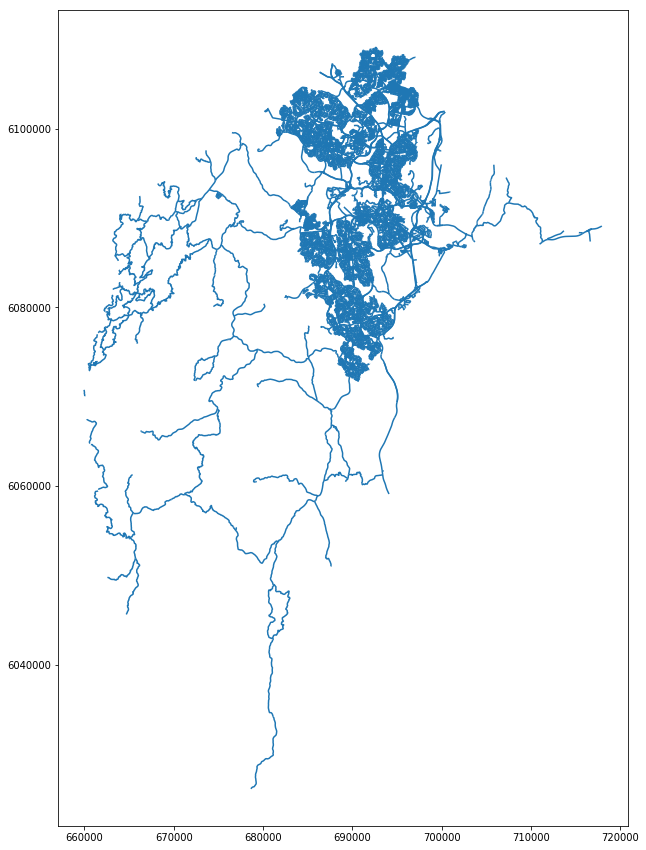

In [151]:
#read in the ACT shapemap

ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')

fig,ax = plt.subplots(figsize = (15,15))
ACT_map_district.plot(ax = ax)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

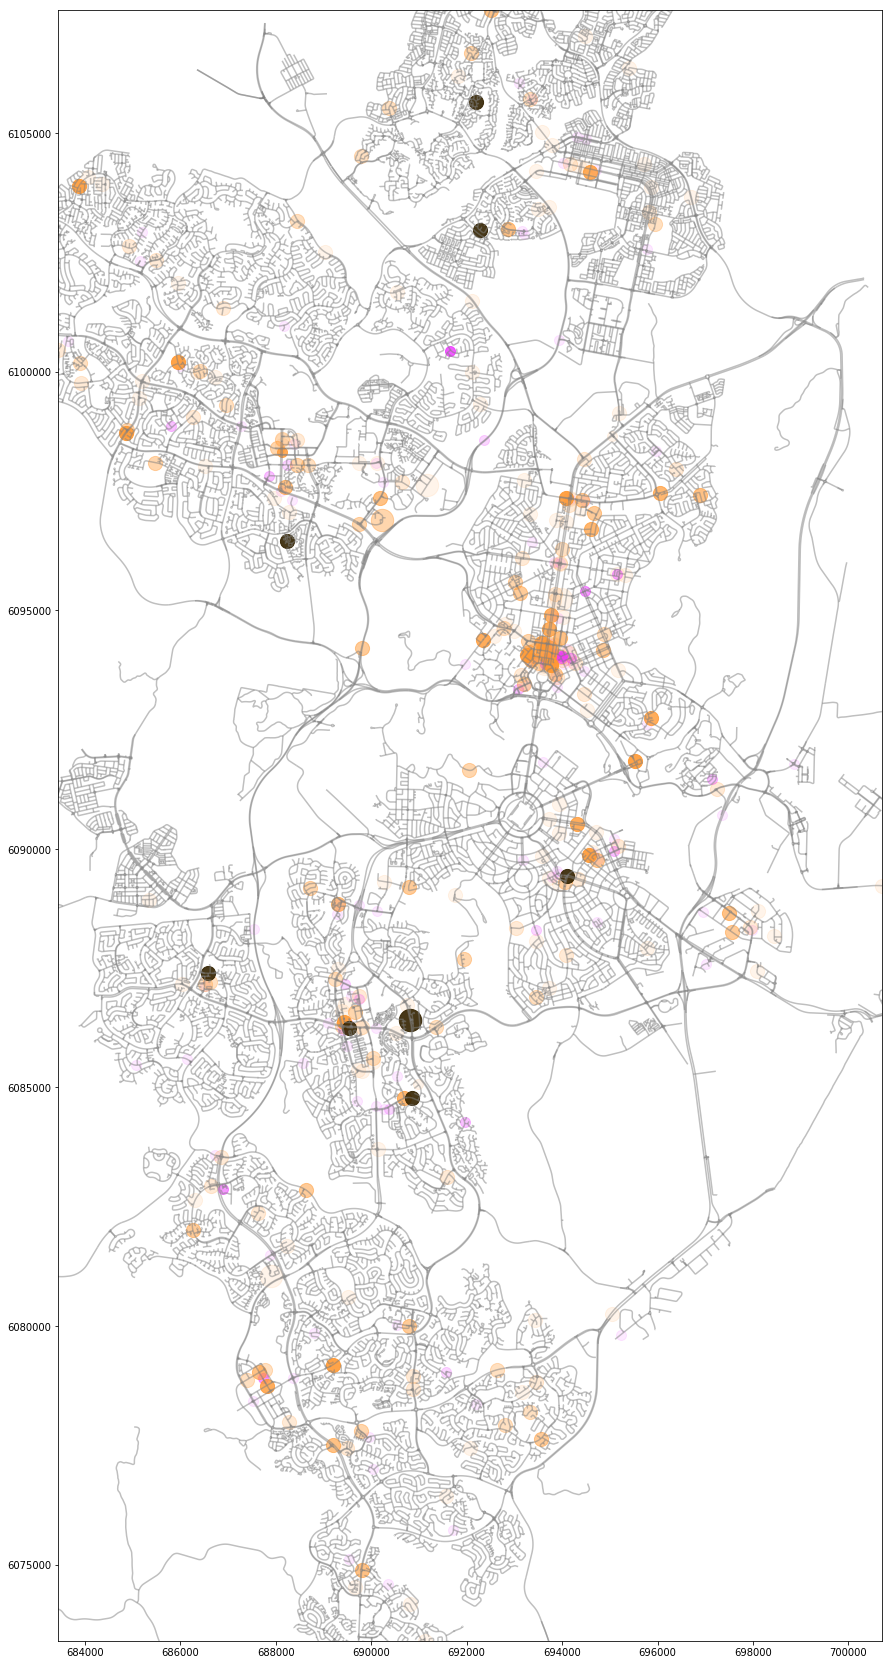

In [173]:
def alphaQuery(year,month,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    return fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def alphaQuery2(year,month,sev,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    return 'Severity == "' + sev + '" and ' + \
           fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def alphaQuery3(year,month,sevIndex,casualties,alpha,delta=0.1):
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    fad = 'Fad'+yy+mm
    if (sevIndex == 1):
        return '(SevIndex == ' + str(sevIndex) + ' and Casualties == ' + str(casualties) + ')'' and (' + \
               fad + ' == 1)'
    else:
        return '(SevIndex == ' + str(sevIndex) + ' and Casualties == ' + str(casualties) + ') and (' + \
               fad + ' <= ' + str(alpha) + ' and ' + fad + ' > ' + str(alpha - delta) + ')'

def plot_yearMonthAlpha(df,ax1,year,month,sev,alpha,colour):
    for casualties in range(0,3):
        markersize = 100 + casualties * casualties * 100
        qr = df.query(alphaQuery3(year,month,sev,casualties,alpha,0.1))
        if qr.size > 0:
            qr.plot(
                ax=ax1, 
                markersize=markersize,
                color=colour,
                alpha=alpha)

#Plot the public pedestrian crash data onto the map, and do some styling
def print_plot_ymd(df, ax1, year, month, day, fileprefix, seq):

#    fig,ax = plt.subplots(figsize=(30,30))
#ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
#act_geo_df.query('Year <= 2012 and Month < 6').plot(
    yy = f'{year - 2000:02}'
    mm = f'{month:02}'
    dd = f'{day:02}'
    sn = f'{seq:05}'
    filename = fileprefix + sn + '.png'
    i_colour = "#FF9933" # '#FF9900'
    p_colour = "#EE33FF"
    f_colour = "#332200"
    compare_date = datetime.datetime(year,month,day,0,0,0)
    #act_geo_df.head()
    df_filt = df[df.CrashDate < compare_date]

    for alpha in np.arange(0.1,1.0,0.1):
        plot_yearMonthAlpha(df_filt,ax1,year,month,0.7,alpha,i_colour)
        plot_yearMonthAlpha(df_filt,ax1,year,month,0.1,alpha,p_colour)
    plot_yearMonthAlpha(df_filt,ax1,year,month,1,alpha,f_colour)
    plt.savefig(filename,bbox_inches='tight',transparent=True)

        
#plt.clf()
#fig,ax = plt.subplots(figsize=(30,30))
#ax.set_xlim(left=min_x, right=max_x)
#ax.set_ylim(bottom=min_y, top=max_y)

# plot all pedestrian accidents - small blue dots
#act_geo_df.plot(
#    ax=ax, 
#    markersize=50,
#    color="#00FFFF")

#bounding_box = act_geo_df.envelope
#bb_df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

#ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')
#intersections = gpd.overlay(bb_df, ACT_map_district, how='intersection')
#ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
#plot_yearMonthAlpha(act_geo_df,2014,6,1,"#FF9900")


#print_plot_ymd(act_geo_df,ax,2014,6,1,"test_ped_crash_",1)
#alphaQuery3(2014,6,0.7,1,0.5,0.1)

def print_act_map(fileprefix):
    filename = fileprefix + '_basemap.png'
    plt.clf()
    fig,ax = plt.subplots(figsize=(15,15))
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_ylim(bottom=min_y, top=max_y)
    ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
    plt.savefig(filename,bbox_inches='tight',transparent=False)


def print_frames(df):
    frame_no = 0
    # plot all pedestrian accidents - small blue dots
    #act_geo_df.plot(
    #    ax=ax, 
    #    markersize=50,
    #    color="#00FFFF")

    #bounding_box = act_geo_df.envelope
    #bb_df = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

    #ACT_map_district = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')
    #intersections = gpd.overlay(bb_df, ACT_map_district, how='intersection')
    for year in range(2012,2019):
        for month in range(1,13):
            for day in range(2,28,2):
                plt.clf()
                fig,ax = plt.subplots(figsize=(15,15))
                ax.set_xlim(left=min_x, right=max_x)
                ax.set_ylim(bottom=min_y, top=max_y)
                #ACT_map_district.plot(ax=ax, alpha=0.5, color='grey')
                print_plot_ymd(df,ax,year,month,day,"ped_crash_",frame_no)
                frame_no += 1

# Print out the ACT street map - to be used as a background                
print_act_map()
# Print out the frames for the animation
print_frames(act_geo_df)


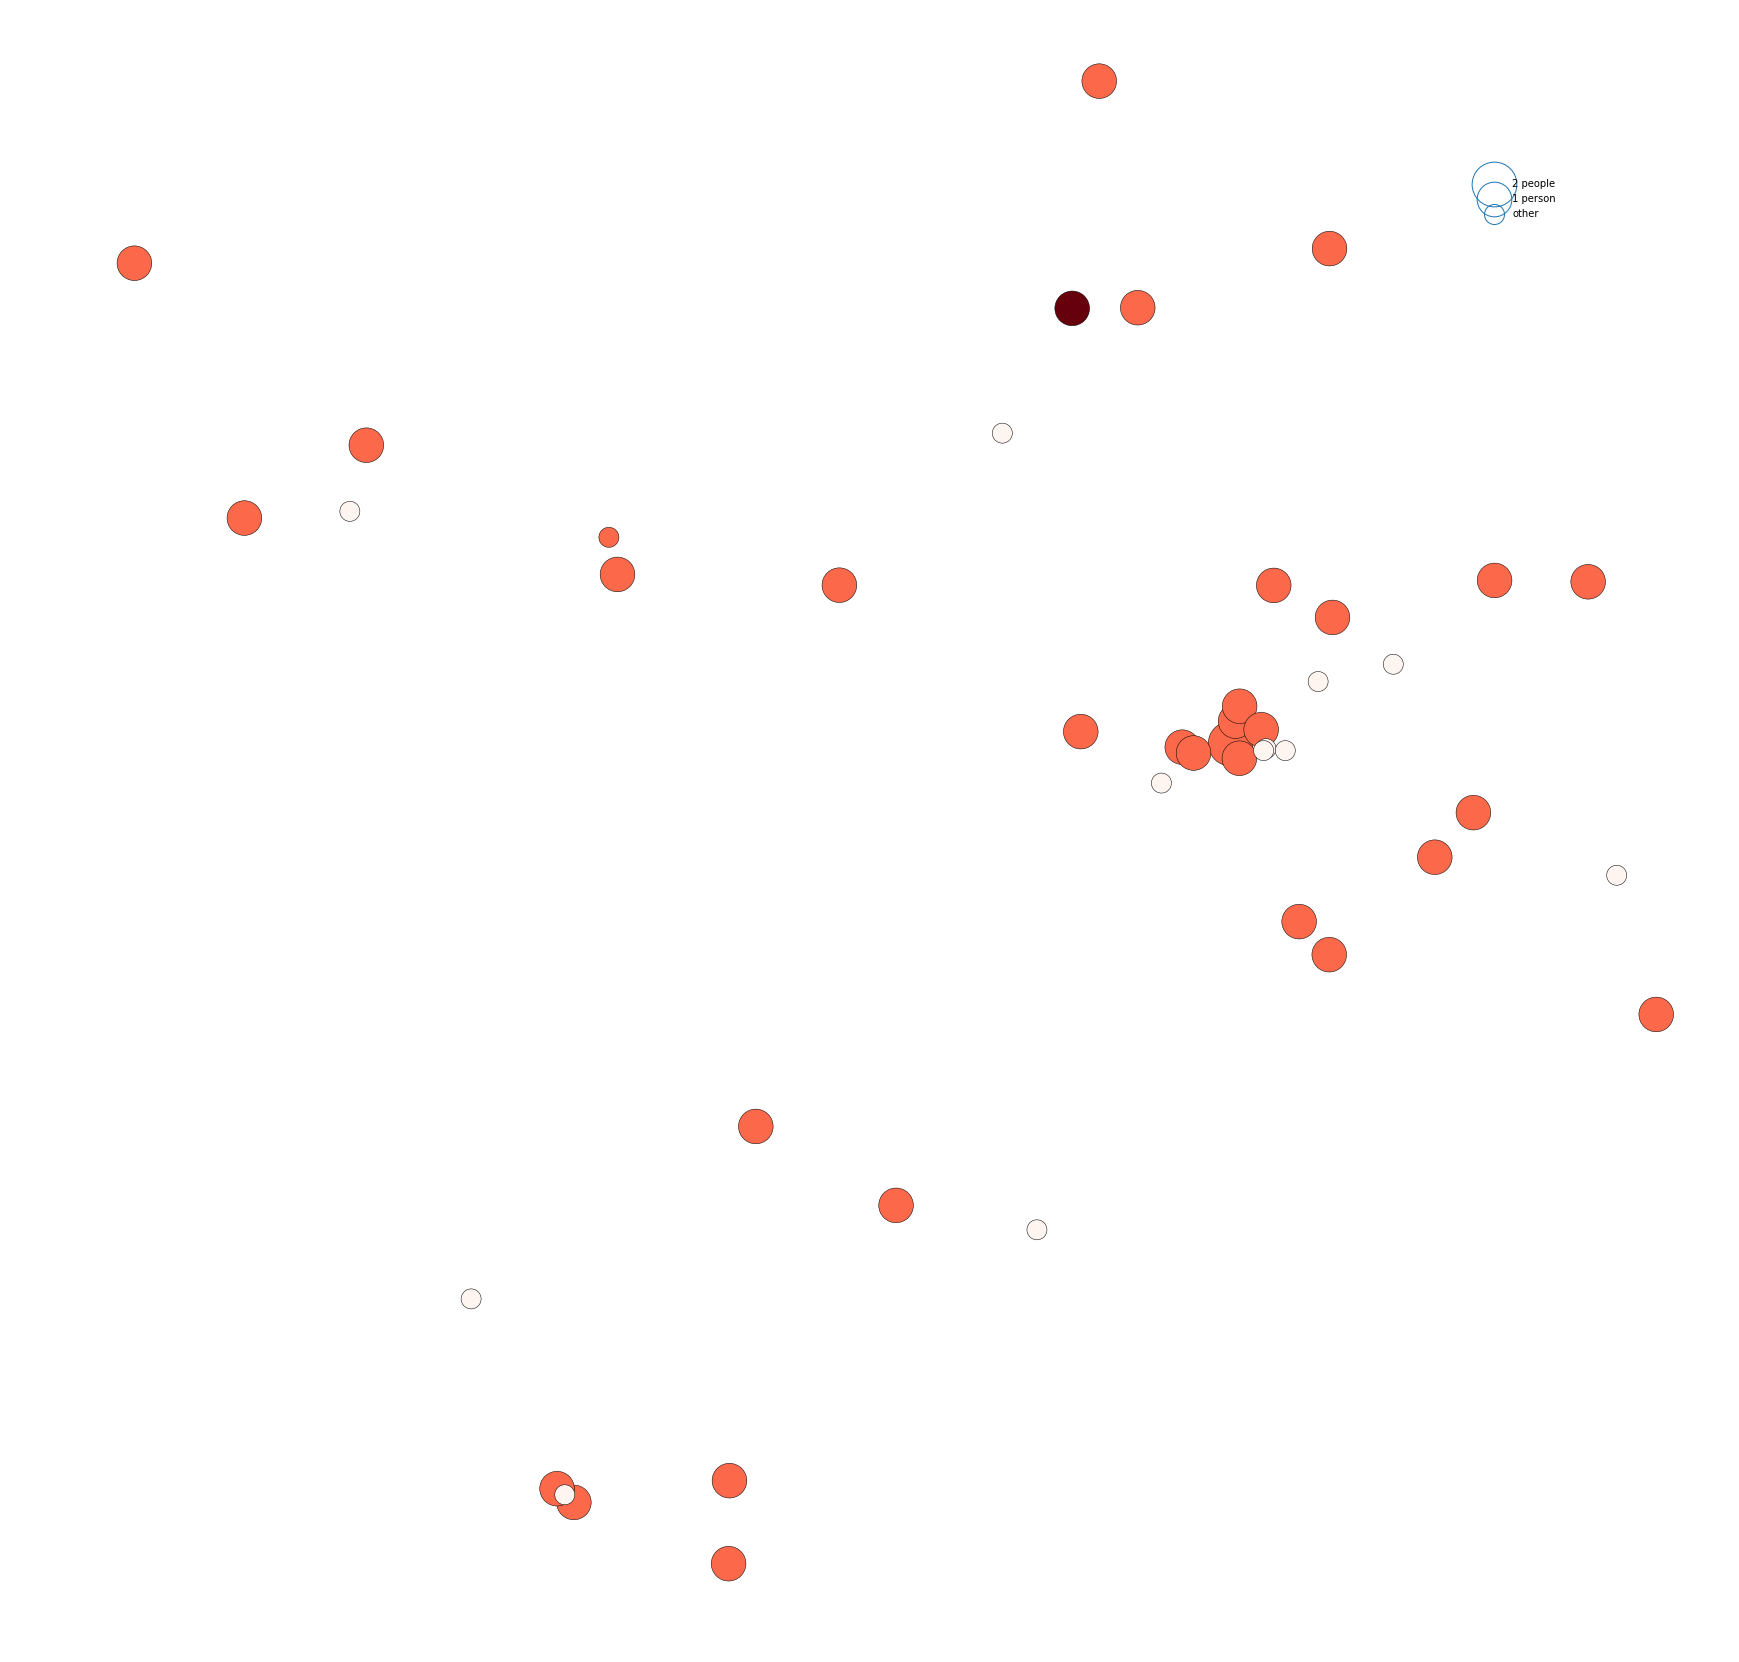

In [57]:
# Plot the figure.
fig,ax = plt.subplots(figsize=(30,30))
point_kwargs = {'linewidth': 0.5, 'edgecolor': 'black'}
legend_kwargs = {'bbox_to_anchor': (0.9, 0.9), 'frameon': False}
poly_kwargs = {'linewidth': 0.5, 'edgecolor': 'gray', 'zorder': -1}
#ax = gplt.polyplot(ACT_map_district,
#                   projection=gcrs.AlbersEqualArea(central_longitude=149, central_latitude=-35),
#                   **poly_kwargs)
#act_geo_fatal = act_geo_df.query('Severity == "Fatal"') 
gplt.pointplot(act_geo_df.query('Year == 2018'),ax=ax,
              scale='CasScale',limits=(20,100),
              #projection=gcrs.AlbersEqualArea(),
              hue='SevIndex', cmap='Reds',
              legend=True,legend_var='scale',legend_values=[3,2,1],legend_labels=['2 people','1 person','other'],
              legend_kwargs=legend_kwargs,
               **point_kwargs)

In [36]:
!pip install mapclassify